In [4]:
import CBB_Funcs as cbb_fun
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from playsound import playsound
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
############# Loading in Data ################
## The process of scraping all the data from the web for all four years
## and performing 'combine_data' could take almost an hour

## By setting load = 'True', data is loaded from files that have
## already been processed. This can be done for all 4 years in about 15 seconds.

## By setting load = 'False', data can either be scraped from the web and then processed (scrape_data = 'True')
## or loaded from a file and then processed (scrape_data = 'False'). In the latter scenario, the processing consists of running
## the 'combine_data' function.

# Get team names and urls
teams_source = pd.read_excel('Team_Source.xlsx', header=None, names=['2016', '2016_Teams', '2016 Conf', '2017', '2017_Teams', '2018', '2018_Teams',
                                                                     '2019', '2019_Teams', '2020', '2020_Teams', '2021', '2021_Teams'])
# select years to be processed
years = ['2016', '2017', '2018', '2019']
#years = ['2016']

# Set data-gathering parameters
load = True
scrape_data = True

# Initialize dataframe
cbb_df = pd.DataFrame()

# loop through each year to be looked at
for yr in years:
    if load:
        sources, teams, team_dict = cbb_fun.get_logistics(teams_source, yr) # #urls and team names for that year
        combined_df = [pd.read_csv('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))] # load pre-processing data into list of dataframes   
#         with open('./Team_Dataframes/' + yr + '/Combined.pickle', 'rb') as f:
#             combined_df = pickle.load(f)
#         combined_df = []
        for ii in range(len(teams)):
            with open('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.pickle', 'rb') as f:
                combined_df.append(pickle.load(f))
        
        cbb_df = pd.concat((cbb_df, pd.concat(combined_df))) # concatenate all dataframes to final output dataframe
    else:
        teams_df, teams, team_dict = cbb_fun.get_team_data(teams_source, yr, scrape_data=scrape_data) # grab data for each team during the 'yr'
        combined_df, next_g = cbb_fun.combine_data(teams_df, team_dict, teams, year=yr) # process the data adding information about opponent and previous games
        cbb_df = pd.concat((cbb_df, pd.concat((combined_df)))) # concatenate all dataframes to final output dataframe

# if loading all years, save to final '.csv' file
# not necesasry for model development
if len(years) == 4:
    cbb_df.to_csv('./Final_Dataframes/Teams_Combined.csv', index=False)

print('DONE LOADING ALL DATA')
playsound('mixkit-intro-transition-1146.wav')

BEGINNING WEB SCRAPE 2016
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
DONE WITH DATA INTAKE 2016
BEGINNING COMBINING DATA 2016
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
BEGINNING WEB SCRAPE 2017
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
DONE WITH DATA INTAKE 2017
BEGINNING COMBINING DATA 2017
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
BEGINNING WEB SCRAPE 2018
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
DONE WITH DATA INTAKE 2018
BEGINNING COMBINING DATA 2018
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
BEGINNING WEB SCRAPE 2019
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
DONE WITH DATA INTAKE 2019
BEGINNING COMBINING DATA 2019
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
DONE LOADING ALL DATA


In [328]:
############# Sending Data to Predictive Models and Looking at Statistics################

# determine features to be sent into models
# features = ['Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 
#             'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']
features = ['SMA_Result', 'SMA_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 'SMA_Pct_Margin', 'SMA_Pct_Margin2', 
            'Prev_Pct_Margin', 'Prev_Pct_Margin2', 'SOS_NC', 'Opp_SOS_NC', 'EMA_Opp_FG_Pct', 'EMA_Opp_FG_Pct2', 'SMA_Comb_Loc', 'SMA_Comb_Loc2', 'Prev_Comb_Loc', 'Prev_Comb_Loc2',
            'Scoring_Pace_Diff', 'Avg_Result_NC', 'Avg_Result_NC2']

# number of features
num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

data['Opp_Scoring_Pace_Diff'] = data['Scoring_Pace_Diff']*-1

# opp_features = ['Avg_Result2', 'Avg_Result', 'Avg_Result_NC2', 'Avg_Result_NC', 'Home2', 'Away2', 'Opp_SOS', 'SOS', 'Opp_Prev_SOS', 'Prev_SOS',
#                 'Opp_SOS_NC', 'SOS_NC', 'Opp_Avg_FG_Pct2', 'Opp_Avg_FG_Pct', 'Pct_Margin2', 'Pct_Margin', 'Home_Pct2', 'Home_Pct', 'Opp_Scoring_Pace_Diff']
opp_features = ['SMA_Result2', 'SMA_Result', 'Home2', 'Away2', 'Opp_SOS', 'SOS', 'Opp_Prev_SOS', 'Prev_SOS', 'SMA_Pct_Margin2', 'SMA_Pct_Margin', 
            'Prev_Pct_Margin2', 'Prev_Pct_Margin', 'Opp_SOS_NC', 'SOS_NC', 'EMA_Opp_FG_Pct2', 'EMA_Opp_FG_Pct', 'SMA_Comb_Loc2', 'SMA_Comb_Loc', 'Prev_Comb_Loc2', 'Prev_Comb_Loc',
            'Opp_Scoring_Pace_Diff', 'Avg_Result_NC2', 'Avg_Result_NC']

# Whether or not to pickle data and/or create distribution models
pickled = False
create_dist = False

# Set number of runs
lin_runs, log_runs, rf_runs, comb_runs = 2000, 1000, 25, 100

X = data[list(set(features + opp_features))]
y = data['result'] # points spread
y2 = data['Win'] # Win (1) or Loss (0) result

#Save Results
if pickled:
    with open('y.pickle', 'wb') as f:
        pickle.dump(y, f)
    with open('y2.pickle', 'wb') as f:
        pickle.dump(y2, f)
    with open('X.pickle', 'wb') as f:
        pickle.dump(X, f)

# Null statistics if winner was chosen at random and points spread was predicted to be 0
cbb_fun.print_null(y)

# Winner always chosen to be home team - 50/50 for neutral-site games
print('\n\nHOME NULL CORRECT PREDICTIONS: ', cbb_fun.home_null(cbb_df[['Away', 'Win']]), '%')

# Send data to Linear Regression model and get statistics (increase n_runs for stability in results - ~20 sec per 100 runs) - set pickled=True to pickle MSE
SE, STD, MSE, CV, model, pct_acc, avg_lin_coefs, lin_lr =  cbb_fun.get_linear_stats(X, y, features, opp_features, n_runs=lin_runs, pickled=pickled)

best_fits1 = X[features].dot(avg_lin_coefs)
best_fits2 = -1 * (X[opp_features].dot(avg_lin_coefs))
best_fits = (best_fits1 + best_fits2) / 2

# Save Best fits
if False:#pickled:
    with open('best_fits.pickle', 'wb') as f:
        pickle.dump(best_fits, f)

# Difference between predicted results and test data
resid = best_fits - y

# Append statistics
print('Best fit SE:', np.std(resid, ddof=num_features) / np.sqrt(np.size(resid)))
print('Best fit STD:', np.std(resid, ddof=num_features))
print('Best fit MSE:', mean_squared_error(y, best_fits))

# Linear Best Fits
data['Lin_ypred'] = best_fits

# Send data to Logistic Regression model and get statistics (increase n_runs for stability in results - ~30 sec per 100 runs) - set pickled=True to pickle coefs and sc
score, avg_log_coefs, log_lr, sc = cbb_fun.get_logistic_stats(X, y2, features, opp_features, n_runs=log_runs, pickled=pickled)

# Log Best Fits
log_best_fit_preds, log_best_fit_probs = cbb_fun.log_best_fit(X[features], X[opp_features], sc, avg_log_coefs)

# Add Logistic Regression Predictions to Dataframe
data['Log_y2pred'] = log_best_fit_preds
data['Log_y2prob'] = log_best_fit_probs

# Send Data to RandomForest models and get statistics
# This does Regression for the points spread and Classification for the Win/Loss result
# Default hyperparameters were selected using results from GridSearchCV tuning - set pickled=True to pickle mse, class_model, and reg_model
rf_mse, rf_acc, rf_reg, rf_class, rf_y_pred, rf_y2_pred = \
cbb_fun.get_rf_stats(X, y, y2, features, opp_features, regr_n_estimators=250, regr_max_depth=12, regr_max_features=5, n_runs=rf_runs, pickled=pickled)

# Add Random Forest Predictions to Dataframe
data['RF_ypred'] = rf_y_pred
data['RF_y2pred'] = rf_y2_pred

# Combine Models - - set pickled=True to pickle average mse and accuracy
mse_av, acc_av, y_tests, y2_tests, y_preds, lin_y2_preds, y2_preds, y2_probs, log_y2_probs, rf_y2_probs = \
cbb_fun.combine_models(X, y, y2, features, opp_features, MSE, rf_mse, regr_n_estimators=250, regr_max_depth=12, regr_max_features=5, n_runs=comb_runs, pickled=pickled)


## Create Confidence Distributions for Given Scores (ie. percent confidence above below a value)
if create_dist:
    val_range = np.linspace(-25, 25, 51)
    prob_dists = cbb_fun.create_pts_spread_odds(y_preds, y_tests, val_range, pickled=pickled)
    dist_models, xs = cbb_fun.create_models(val_range, prob_dists, pickled=pickled)
    
    # Win probabilities (combines RF and Log)
    val_range = np.linspace(0.05, 0.95, 91)
    win_pcts = cbb_fun.create_pct_odds(y2_probs, y2_tests, val_range, pickled=pickled)
    pct_model, xs2 = cbb_fun.create_pct_models(val_range, win_pcts, pickled=pickled)
    
playsound('mixkit-intro-transition-1146.wav')

NULL STATISTICS
Standard Error: 0.07949575963209486
Standard Deviation: 14.160959687437149
Mean-squared Error: 200.55760746249842
Percent Win/Loss Prediction: 50 %


HOME NULL CORRECT PREDICTIONS:  63.378092191231474 %


LINEAR STATISTICS
Standard Error: 0.12446949699296445
Standard Deviation: 11.086173258739018
Mean-squared Error: 122.56674638255464
Percent Win/Loss Prediction:  71.86650699609227 %
Cross-validation score: 0.38816634529057764
                                 OLS Regression Results                                
Dep. Variable:                 result   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.388
Method:                 Least Squares   F-statistic:                              655.7
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:31:50   Log-Likelihood:                         -91041.
No. Observations:        

In [71]:
################ Make Predictions ##################

# Grab pickled model data
log_reg_coef, sc, lin_reg_coef, rf_mse, lin_mse, av_mse, rf_class, rf_reg, dist_models, val_range, pct_model, pct_dists, pct_val_range, next_g = cbb_fun.get_pickles(years[-1])

print('CREATING NEXT GAME STATISTICS')

# Grab previous SOS for all teams and add to next_game stats
next_g = cbb_fun.get_next_games(next_g, combined_df, team_dict)

# Set matchups (0 - away, 1 - home, 2 - neutral)
matchups = [['Gonzaga', 'Norfolk State', 2],
            ['Oklahoma', 'Missouri', 2],
            ['Creighton', 'UCSB', 2],
            ['Virginia', 'Ohio', 2],
            ['USC', 'Drake', 2],
            ['Kansas', 'Eastern Washington', 2],
            ['Oregon', 'VCU', 2],
            ['Iowa', 'Grand Canyon', 2],
            ['Michigan', 'Texas Southern', 2],
            ['LSU', 'St. Bonaventure', 2],
            ['Colorado', 'Georgetown', 2],
            ['Florida State', 'UNC Greensboro', 2],
            ['BYU', 'UCLA', 2],
            ['Texas', 'Abilene Christian', 2],
            ['UConn', 'Maryland', 2],
            ['Alabama', 'Iona', 2],
            ['Baylor', 'Hartford', 2],
            ['UNC', 'Wisconsin', 2],
            ['Villanova', 'Winthrop', 2],
            ['Purdue', 'North Texas', 2],
            ['Texas Tech', 'Utah State', 2],
            ['Arkansas', 'Colgate', 2],
            ['Florida', 'Virginia Tech', 2],
            ['Ohio State', 'Oral Roberts', 2],
            ['Illinois', 'Drexel', 2],
            ['Loyola (IL)', 'Georgia Tech', 2],
            ['Tennessee', 'Oregon State', 2],
            ['Oklahoma State', 'Liberty', '2'],
            ['San Diego State', 'Syracuse', 2],
            ['West Virginia', 'Morehead State', 2],
            ['Clemson', 'Rutgers', 2],
            ['Houston', 'Cleveland State', 2]]

matchups = [['Gonzaga', 'Oklahoma', 2],
            ['Creighton', 'Virginia', 2],
            ['USC', 'Kansas', 2],
            ['Iowa', 'VCU', 2],
            ['Michigan', 'St. Bonaventure', 2],
            ['Colorado', 'Florida State', 2],
            ['BYU', 'Abilene Christian', 2],
            ['UConn', 'Alabama', 2],
            ['Baylor', 'UNC', 2],
            ['North Texas', 'Winthrop', 2],
            ['Texas Tech', 'Colgate', 2],
            ['Ohio State', 'Virginia Tech', 2],
            ['Illinois', 'Loyola (IL)', 2],
            ['Tennessee', 'Liberty', 2],
            ['San Diego State', 'West Virginia', 2],
            ['Clemson', 'Houston', 2]]

# matchups = [['Gonzaga', 'Virginia', 2],
#             ['USC', 'Iowa', 2],
#             ['Michigan', 'Colorado', 2],
#             ['BYU', 'Alabama', 2],
#             ['Baylor', 'Winthrop', 2],
#             ['Ohio State', 'Colgate', 2],
#             ['Illinois', 'Tennessee', 2],
#             ['San Diego State', 'Houston', 2]]

# matchups = [['Gonzaga', 'USC', 2],
#             ['Michigan', 'Alabama', 2],
#             ['Baylor', 'Colgate', 2],
#             ['Illinois', 'Houston', 2]]

# matchups = [['Gonzaga', 'Alabama', 2],
#             ['Baylor', 'Houston', 2]]



print('CREATING MATCHUPS')
# Create matchup values based off data from two teams in matchups
matchup_vals = cbb_fun.create_matchups(matchups, next_g, team_dict)

print('\n\nMaking Predictions')
lin_preds = cbb_fun.lin_regr_predict(lin_reg_coef, matchup_vals, matchups)
rf_reg_preds = cbb_fun.rf_regr_predict(rf_reg, matchup_vals, matchups)
log_reg_preds, log_reg_probs = cbb_fun.log_regr_predict(log_reg_coef, matchup_vals, sc, matchups)
rf_class_preds, rf_class_probs = cbb_fun.rf_class_predict(rf_class, matchup_vals, sc, matchups)

# Weight the MSE based on which model (linear and RF) performs better and worse
lin_weight = 1 - (lin_mse/ (lin_mse+rf_mse))
rf_regr_weight = 1 - (rf_mse / (lin_mse+rf_mse))

# Combined points spread and probability of winning 
final_pts_spread = [(lin_weight * lin_pred) + (rf_regr_weight * rf_reg_pred[0]) for lin_pred, rf_reg_pred in zip(lin_preds, rf_reg_preds)]
final_probs = np.mean([log_reg_probs, rf_class_probs], axis=0)

np.set_printoptions(suppress=True)
   
cbb_fun.show_confidence(final_pts_spread, final_probs, dist_models, pct_model, val_range, pct_val_range, matchups)

np.set_printoptions(suppress=False)

playsound('mixkit-intro-transition-1146.wav') 

CREATING NEXT GAME STATISTICS
CREATING MATCHUPS


Making Predictions
Linear Regression model points spread: Gonzaga 12.9896 to Oklahoma ((12.988821992447118, 12.990418038625512))

Linear Regression model points spread: Creighton -10.9044 to Virginia ((-10.929510015856879, -10.879291527965854))

Linear Regression model points spread: USC -7.0872 to Kansas ((-7.12163488712843, -7.05283628381353))

Linear Regression model points spread: Iowa -3.3054 to VCU ((-3.2954142278034353, -3.315353958234346))

Linear Regression model points spread: Michigan 10.5877 to St. Bonaventure ((10.606440677802457, 10.56900732987839))

Linear Regression model points spread: Colorado -5.6561 to Florida State ((-5.6406074488943405, -5.6715930972236475))

Linear Regression model points spread: BYU 3.643 to Abilene Christian ((3.697001343636115, 3.5889876809928234))

Linear Regression model points spread: UConn -1.324 to Alabama ((-1.302817811732147, -1.3451498451987778))

Linear Regression model points spread: 

In [29]:
##### Rank Teams #####

log_reg_coef, sc, lin_reg_coef, rf_mse, lin_mse, av_mse, rf_class, rf_reg, dist_models, val_range, pct_dists, pct_val_range, next_g = cbb_fun.get_pickles(years[-1])    
    
print('CREATING NEXT GAME STASTICS')
    
next_g = cbb_fun.get_next_games(next_g, combined_df, team_dict)

rankings = cbb_fun.get_rankings(teams, next_g, team_dict, lin_reg_coef, lin_mse, rf_mse, rf_reg, print_out=False)                

playsound('mixkit-intro-transition-1146.wav')
pd.DataFrame(rankings).head(60)

CREATING NEXT GAME STASTICS
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


,0
0,Gonzaga
1,Houston
2,Baylor
3,Colgate
4,Illinois
5,Alabama
6,San Diego State
7,Michigan
8,BYU
9,USC


In [3]:
# X = data[features]
# y = data['result']

# lrs = []
# lrcvs = []
# rfs = []
# rfcvs = []

# for ii in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(X, y)
#     lrcvs.append(cross_val_score(LinearRegression(fit_intercept=False), X, y, cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error').mean())
#     rfcvs.append(cross_val_score(RandomForestRegressor(n_estimators=130, max_depth=9, max_features=9), X, y, cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error').mean())
#     rfg = RandomForestRegressor(n_estimators=130, max_depth=9, max_features=9)
#     lr = LinearRegression(fit_intercept=False)
#     rfg.fit(X_train, y_train)
#     lr.fit(X_train, y_train)

#     y_pred = rfg.predict(X_test)
#     y_pred2 = lr.predict(X_test)
#     #print(mean_squared_error(y_pred, y_test), mean_squared_error(y_pred2, y_test))
#     lrs.append(mean_squared_error(y_pred2, y_test))
#     rfs.append(mean_squared_error(y_pred, y_test))
#     print(ii)
    
# print(np.mean(lrs), np.mean(lrcvs), np.mean(rfs), np.mean(rfcvs))
# playsound('mixkit-intro-transition-1146.wav')
# from contextlib import contextmanager
# import io
# import sys
# def nostdout():
#     with open(os.devnull, 'w') as devnull:
#         save_stdout = sys.stdout
#         sys.stdout = devnull
#         try:
#             yield
#         finally:
#             sys.stdout = save_stdout
rankings = pd.DataFrame(rankings)
rankings[rankings[0] == 'Duke']

NameError: name 'rankings' is not defined

In [31]:
combined_df[0]['Date'].diff().dt.days, combined_df[0]

(pandas.core.series.Series,
          Date Loc                  Opp_name         W  Score  Opp_score    FG  \
 0  2018-11-09                Arkansas State         W   94.0       73.0  31.0   
 1  2018-11-15   @                    Denver         W   67.0       61.0  22.0   
 2  2018-11-22   N                      Elon         W   72.0       56.0  29.0   
 3  2018-11-23   @                   Pacific         W   73.0       71.0  28.0   
 4  2018-11-24   N              UC-Riverside         W   60.0       48.0  22.0   
 5  2018-12-01   @                Pepperdine         L   62.0       77.0  25.0   
 6  2018-12-04                      Campbell         W   83.0       68.0  27.0   
 7  2018-12-15   @                Texas Tech         L   48.0       82.0  15.0   
 8  2018-12-21   @  Southeast Missouri State         W   70.0       68.0  23.0   
 9  2019-01-02                   New Orleans         W   68.0       58.0  24.0   
 10 2019-01-05   @         Sam Houston State         L   68.0       71

In [172]:
with open('rf_reg.pickle', 'rb') as f:
    rf_reg_test = pickle.load(f)
    
with open('lin_reg_coef.pickle', 'rb') as f:
    lin_reg_coef = pickle.load(f)

years = ['2016', '2017', '2018', '2019']
train_dfs = []
test_dfs = []
for yr in years:
    sources, teams, team_dict = cbb_fun.get_logistics(teams_source, yr) # #urls and team names for that year
    #combined_df = [pd.read_csv('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))] # load pre-processing data into list of dataframes   

    combined_df = []
    len_df = len(teams)
    for ii in range(len_df):
        with open('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.pickle', 'rb') as f:
            combined_df.append(pickle.load(f))  

    rand_idxs = random.sample(list(range(len_df)), round(len_df * 0.75))
    
    for jj in range(len_df):
        #print(ii)
        df = combined_df[jj].copy()
        df['Opp_Scoring_Pace_Diff'] = df['Scoring_Pace_Diff']*-1
        data = df[features]
        opp_data = df[opp_features]
        prediction1 = np.array(data).dot(lin_reg_coef)
        prediction2 = -1 * np.array(opp_data).dot(lin_reg_coef)
        df['prediction'] = np.mean([prediction1, prediction2], axis=0)
        df['performance'] = df['result'] - df['prediction']
        df['av_performance'] = cbb_fun.running_means([df['performance']])[0]
        if jj in rand_idxs:
            train_dfs.append(df[10:])
        else:
            test_dfs.append(df[10:])

In [272]:
# test = pd.concat((train_dfs))
# print(mean_squared_error(test['result'], test['prediction']))

# y = test['result']
# new_features = features +['av_performance']
# model = sm.OLS(y, test[new_features], missing='drop') # sm.add_constant(X)
# results = model.fit()
# results.summary()

# Calculate simple moving average and exponentially weighted moving average 
def mov_avgs(test, test_feats):
    len_test = len(test)
    for col in test[test_feats]:
        sma = test[col].expanding().mean()
        test['SMA_' + col + '_Fin'] = [list(sma)[-1]] * len_test
        test['SMA_' + col] = sma.shift(1)
        ema = test[col].ewm(span=len_test).mean()
        test['EMA_' + col + '_Fin'] = [list(ema)[-1]] * len_test
        test['EMA_' + col] = ema.shift(1)
        last_3 = test[col].rolling(3).mean()
        test['Last3Avg_' + col + '_Fin'] = [list(last_3)[-1]] * len_test
        test['Last3Avg_' + col] = last_3.shift(1)
        prev = test[col].rolling(1).mean()
        test['Prev_' + col + '_Fin'] = [list(prev)[-1]] * len_test
        test['Prev_' + col] = prev.shift(1)
        
    return test

def home_pcts(test, test_feats, prfxs):
    game_numbers = test['Game_Number']
    for col in test[test_feats]:
        for prfx in prfxs:
            test[prfx + col] = (test[prfx + col] ** 2) * game_numbers
            
    return test

def three_pt_pcts(test, test_feats, prfxs):
    # Loop through each column of interest in the dataframe
    for col in test[test_feats]:
        # Loop through the different averages
        for prfx in prfxs:
            if col == 'Threes':
                test[prfx + col] = (3*test[prfx + col])/test[prfx+'Score'] - threes_pct
            else:
                test[prfx + col] = (3*test[prfx + col])/test[prfx+'Opp_score'] - threes_pct
    
    return test

def avg_results(test, prfxs):
    # Loop through the different averages
    for prfx in prfxs:
        test[prfx + 'Result'] = test[prfx + 'Score'] - test[prfx + 'Opp_score']
    return test

def pct_margins(test, prfxs):
    # Loop through the different averages
    for prfx in prfxs:
        test[prfx + 'Pct_Margin'] = test[prfx + 'Result'] / test[prfx + 'Mean_Score']
    return test

def create_fins(test, prfxs):
    # Loop through each column of interest in the dataframe
    for prfx in prfxs:
        test[prfx + 'Result_Fin'] = test[prfx + 'Score_Fin'] - test[prfx + 'Opp_score_Fin']
        test[prfx + 'Pct_Margin_Fin'] = test[prfx + 'Result_Fin'][0] / test[prfx + 'Mean_Score_Fin'][0]
    return test

threes_pct = 0.31352436210388857
avg_prefixes = ['SMA_', 'EMA_', 'Last3Avg_', 'Prev_']
combined_df_copy = combined_df.copy()

for test in combined_df_copy:
    
    #test = df.copy()
    
    # Calculate Moving Averages for Key Metrics
    test_feats = ['Score', 'Opp_score', 'Threes', 'Opp_Threes', 'FG_Pct', 'Opp_FG_Pct', 'Mean_Score', 'Comb_Loc']
    test = mov_avgs(test, test_feats)

    # Adjust Percentage of games played at homes
    test_feats = ['Comb_Loc']
    test = home_pcts(test, test_feats, avg_prefixes)

    # Convert Number of Threes to Pct of Points Scored by 3s
    test_feats = ['Threes', 'Opp_Threes']
    test = three_pt_pcts(test, test_feats, avg_prefixes)

    # Grab Average Game Results
    test = avg_results(test, avg_prefixes)

    # Calculates the percent margin of victory/loss as percentage of mean scores
    test = pct_margins(test, avg_prefixes)

    # Calculate Finals Columns
    test = create_fins(test, avg_prefixes)

len(combined_df_copy)
#test[['Pct_Margin_Fin', 'SMA_Pct_Margin_Fin', 'SMA_Pct_Margin', 'EMA_Pct_Margin_Fin', 'EMA_Result_Fin', 'SMA_Result_Fin', 'Avg_Result_Fin', 'EMA_Opp_FG_Pct_Fin', 'SMA_Opp_FG_Pct_Fin', 'Opp_Avg_FG_Pct_Fin', 'Pct_Margin', 'SMA_Pct_Margin', 'Avg_Threes', 'SMA_Threes', 'EMA_Threes', 'Opp_Avg_Threes', 'SMA_Opp_Threes', 'Home_Pct', 'SMA_Comb_Loc', 'SMA_Score', 'Avg_Score', 'EMA_Score', 'SMA_Opp_score', 'Opp_Avg_Score', 'EMA_Opp_score', 'Avg_Result', 'SMA_Result', 'EMA_Result', 'result', 'Score', 'Opp_score', 'Last3Avg_Score', 'Last3Avg_Opp_score', 'Prev_Score', 'Prev_Opp_score']]

353

In [14]:
#(abs(a).sort_values() - abs(data['result']).sort_values())[:10]
# pd.Series(abs(a).sort_values().values - abs(data['result']).sort_values().values).plot()
#pd.Series(a.sort_values().values - data['result'].sort_values().values).plot()
#print(a.sort_values().values[:10])
sc_grid = StandardScaler()
Xsc = sc_grid.fit_transform(data)

rf_class = RandomForestClassifier()
params = {'n_estimators': range(175, 276, 25), 'max_depth': range(4, Xsc.shape[1]), 'max_features': range(4, Xsc.shape[1])}
cvtree = GridSearchCV(rf_class, params)
cvtree.fit(Xsc, y2)
best_params = cvtree.best_params_
print(best_params)
# {'max_depth': 9, 'max_features': 8, 'n_estimators': 200} - 70.79916

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}


In [15]:
accs = cross_val_score(RandomForestClassifier(n_estimators=200, max_depth=9, max_features=8), \
                                     Xsc, y2, cv=KFold(10, shuffle=True), scoring='accuracy').mean()
accs

0.7079916080683126

In [4]:
teams_source = pd.read_excel('Team_Source.xlsx', header=None, names=['2016', '2016_Teams', '2016 Conf', '2017', '2017_Teams', '2018', '2018_Teams',
                                                                     '2019', '2019_Teams', '2020', '2020_Teams', '2021', '2021_Teams'])
# select years to be processed
#years = ['2016', '2017', '2018', '2019']
years = ['2021']

# Set data-gathering parameters
load = False
scrape_data = True

# Initialize dataframe
cbb_df = pd.DataFrame()

# loop through each year to be looked at
# for yr in years:
#     if load:
#         sources, teams, team_dict = cbb_fun.get_logistics(teams_source, yr) # #urls and team names for that year
#         #combined_df = [pd.read_csv('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))] # load pre-processing data into list of dataframes   
# #         with open('./Team_Dataframes/' + yr + '/Combined.pickle', 'rb') as f:
# #             combined_df = pickle.load(f)
#         combined_df = []
#         for ii in range(len(teams)):
#             with open('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.pickle', 'rb') as f:
#                 combined_df.append(pickle.load(f))
        
#         cbb_df = pd.concat((cbb_df, pd.concat(combined_df))) # concatenate all dataframes to final output dataframe
#     else:
#         teams_df, teams, team_dict = cbb_fun.get_team_data(teams_source, yr, scrape_data=scrape_data) # grab data for each team during the 'yr'

teams_df, teams, team_dict = cbb_fun.get_team_data(teams_source, '2021', scrape_data=scrape_data) # grab data for each team during the 'yr'
teams_df[0]['Home_Pct']

BEGINNING WEB SCRAPE 2021
0
DONE WITH DATA INTAKE 2021


0          NaN
1     0.000000
2     0.000000
3     0.000000
4     0.250000
5     0.000000
6    -0.166667
7     0.000000
8    -0.125000
9     0.000000
10   -0.100000
11    0.000000
12    0.083333
13    0.000000
14   -0.071429
15   -0.133333
16   -0.062500
17    0.000000
18    0.055556
19    0.000000
20   -0.050000
21    0.000000
Name: Home_Pct, dtype: float64

In [228]:
df[['av_performance', 'performance', 'result', 'prediction', 'Rest_Days']]

,av_performance,performance,result,prediction,Rest_Days
0,NaN,NaN,-16.0,NaN,NaN
1,NaN,NaN,-29.0,NaN,4.0
2,NaN,16.250298,11.0,-5.250298,6.0
3,16.250298,8.216846,-6.0,-14.216846,1.0
4,12.233572,-7.440768,-9.0,-1.559232,1.0
5,5.675459,-19.758644,-20.0,-0.241356,10.0
6,-0.683067,-15.374636,-34.0,-18.625364,3.0
7,-3.621381,5.838269,-6.0,-11.838269,3.0
8,-2.044773,-5.453176,-11.0,-5.546824,4.0
9,-2.531687,12.975238,10.0,-2.975238,7.0


[(0.9963254426324796, -25.0, -27114.16214205945),
 (0.9974596945309941, -24.0, -39265.34453044928),
 (0.9962129794589769, -23.0, -26305.982992895075),
 (0.9959861313350681, -22.0, -24813.620336826876),
 (0.9939040011897248, -21.0, -16304.20267658896),
 (0.9917677167581848, -20.0, -12047.298272253047),
 (0.9913929192574829, -19.0, -11518.341106761236),
 (0.9917389456263626, -18.0, -12004.992350506556),
 (0.9913309758981088, -17.0, -11435.323794772303),
 (0.9895113133512535, -16.0, -9434.082135245337),
 (0.9879111574350784, -15.0, -8172.09052173214),
 (0.9856459582704911, -14.0, -6866.678924614013),
 (0.9798389282959546, -13.0, -4860.053784240787),
 (0.9778784064147612, -12.0, -4420.469993026523),
 (0.9754979554098564, -11.0, -3981.292058387113),
 (0.9705259870887739, -10.0, -3292.819304965152),
 (0.9668860786059721, -9.0, -2919.877918114373),
 (0.9591223673464766, -8.0, -2346.325618892723),
 (0.9498895987412577, -7.0, -1895.593678918184),
 (0.9398541364391856, -6.0, -1562.6247272830067)

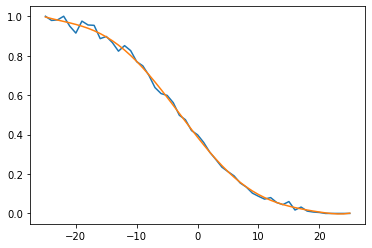

In [34]:
def create_models(val_range, prob_dists):
    xs = np.round(val_range, 0)
    models = []
    for x2 in xs:
        coefs_fit = np.polyfit(xs, prob_dists[int(x2)-int(xs[0])], 7)
        models.append(coefs_fit)
    
    return models, xs

dist_models, xs = create_models(val_range, prob_dists)

def get_confidence(models, prediction, xs):

    pcts = []

    for ii, model in enumerate(models):

        pct = 1 - (model[0]*(prediction**7) + model[1]*(prediction**6) + model[2]*(prediction**5) + model[3]*(prediction**4) + model[4]*(prediction**3) + model[5]*(prediction**2) + model[6]*prediction + model[7])

        if pct > 0.5:
            odds = -(100*pct)/(1-pct)
        else:
            odds = (100/pct) - 100

        pcts.append((pct, ii+xs[0], odds))
#         d = []
#         for x in xs:

#             d.append(model[0]*(x**7) + model[1]*(x**6) + model[2]*(x**5) + model[3]*(x**4) + model[4]*(x**3) + model[5]*(x**2) + model[6]*x + model[7])

#         models.append(d)
#     plt.plot(xs, prob_dists[10])
#     plt.plot(xs, d);
    
    return pcts

d = []
num = 22
for x in xs:
    
    d.append(dist_models[num][0]*(x**7) + dist_models[num][1]*(x**6) + dist_models[num][2]*(x**5) + dist_models[num][3]*(x**4) + dist_models[num][4]*(x**3) + dist_models[num][5]*(x**2) + dist_models[num][6]*x + dist_models[num][7])

#models.append(d)
plt.plot(xs, prob_dists[num])
plt.plot(xs, d);

prediction = 10

confidence = get_confidence(dist_models, prediction, xs)

#np.set_printoptions(suppress=True)
confidence
#np.set_printoptions(suppress=False)

In [5]:
test = LinearRegression(fit_intercept=False)
test.fit(data[features], y)
test2 = test.predict(data[features])
a, b, c, d = train_test_split(data[features], y)
test3 = LinearRegression(fit_intercept=False)
test3.fit(a, c)
test4 = test3.predict(b)
with open('lin_reg_coef.pickle', 'rb') as f:
        lin_reg_coef = pickle.load(f)  
mean_squared_error(y, test2), test.coef_, lin_reg_coef, mean_squared_error(d, test4), test3.coef_

NameError: name 'data' is not defined

In [325]:
# features = ['SMA_Result', 'SMA_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 
#             'SOS_NC', 'Opp_SOS_NC', 'SMA_Opp_FG_Pct', 'SMA_Opp_FG_Pct2', 'SMA_Pct_Margin', 'SMA_Pct_Margin2', 'SMA_Comb_Loc', 'SMA_Comb_Loc2', 'Scoring_Pace_Diff']

features = ['SMA_Result', 'SMA_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 'SMA_Pct_Margin', 'SMA_Pct_Margin2', 
            'Prev_Pct_Margin', 'Prev_Pct_Margin2', 'SOS_NC', 'Opp_SOS_NC', 'EMA_Opp_FG_Pct', 'EMA_Opp_FG_Pct2', 'SMA_Comb_Loc', 'SMA_Comb_Loc2', 'Prev_Comb_Loc', 'Prev_Comb_Loc2',
            'Scoring_Pace_Diff', 'Avg_Result_NC', 'Avg_Result_NC2']

data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)
#data['test'] = cbb_fun.running_means([data['Comb_Loc']])[0]
#data['test2'] = (data['test'] * abs(data['test'])) * data['Game_Number']
y = data['result']

model = sm.OLS(y, data[features], missing='drop') # sm.add_constant(X)
results = model.fit()
preds = results.predict(data[features])
print(mean_squared_error(y, preds))
results.summary()

# test_cbb = pd.concat((combined_df_copy))
# features = ['Last3Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 
#             'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']

# data = test_cbb[test_cbb['Game_Number'] > 9].dropna(subset=features)
# #data['test'] = cbb_fun.running_means([data['Comb_Loc']])[0]
# #data['test2'] = (data['test'] * abs(data['test'])) * data['Game_Number']
# y = data['result']

# model = sm.OLS(y, data[features], missing = 'drop') # sm.add_constant(X)
# results = model.fit()
# results.summary()

122.43704426938596


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 result   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.389
Method:                 Least Squares   F-statistic:                              879.6
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                        0.00
Time:                        18:49:03   Log-Likelihood:                     -1.2130e+05
No. Observations:               31732   AIC:                                  2.427e+05
Df Residuals:                   31709   BIC:                                  2.428e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
SMA_Result            0.6791      0.117      5.784      0.000       0.449       0.909
SMA_Result2          -0.6648      0.118     -5.645      0.000      -0.896      -0.434
Home                  3.2408      0.235     13.807      0.000       2.781       3.701
Away                 -3.3589      0.235    -14.278      0.000      -3.820      -2.898
SOS                   0.7589      0.072     10.490      0.000       0.617       0.901
Opp_SOS              -0.7662      0.072    -10.619      0.000      -0.908      -0.625
Prev_SOS              1.2087      0.090     13.441      0.000       1.032       1.385
Opp_Prev_SOS         -1.2139      0.089    -13.662      0.000      -1.388      -1.040
SMA_Pct_Margin       16.0055      8.116      1.972      0.049       0.097      31.914
SMA_Pct_Margin2     -16.8744      8.140     -2.073      0.038     -32.829      -0.920
Prev_Pct_Margin       1.2571      0.358      3.511      0.000       0.555       1.959
Prev_Pct_Margin2     -1.2532      0.359     -3.494      0.000      -1.956      -0.550
SOS_NC                0.1496      0.062      2.422      0.015       0.029       0.271
Opp_SOS_NC           -0.1657      0.062     -2.680      0.007      -0.287      -0.044
EMA_Opp_FG_Pct       19.9196      2.528      7.880      0.000      14.965      24.874
EMA_Opp_FG_Pct2     -19.8149      2.527     -7.841      0.000     -24.768     -14.862
SMA_Comb_Loc         -0.1133      0.040     -2.840      0.005      -0.191      -0.035
SMA_Comb_Loc2         0.1270      0.040      3.168      0.002       0.048       0.206
Prev_Comb_Loc         0.0510      0.013      4.020      0.000       0.026       0.076
Prev_Comb_Loc2       -0.0530      0.013     -4.209      0.000      -0.078      -0.028
Scoring_Pace_Diff    -0.1396      0.024     -5.922      0.000      -0.186      -0.093
Avg_Result_NC        -0.0735      0.029     -2.503      0.012      -0.131      -0.016
Avg_Result_NC2        0.0741      0.029      2.526      0.012       0.017       0.132
==============================================================================
Omnibus:                      127.643   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.018
Skew:                           0.008   Prob(JB):                     6.00e-39
Kurtosis:                       3.365   Cond. No.                     3.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
## Square the x-variables to represent
X2s = pd.concat((X, X[['SOS_NC', 'Opp_SOS_NC']] ** 3), axis = 1)

## Split the data up into train and test values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y, shuffle=True)

## Create Linear Regression model
lr = LinearRegression(fit_intercept=False)
lr.fit(X2_train, y2_train)

## Calculate scores of new model on training data (MSE and R^2)
y2_pred_train = lr.predict(X2_train)
print('Train MSE:', mean_squared_error(y2_train, y2_pred_train))
print('Train Score:', lr.score(X2_train, y2_train))

## Calculate scores of new model on test data (MSE and R^2)
y2_pred_test = lr.predict(X2_test)
print('Test MSE:', mean_squared_error(y2_test, y2_pred_test))
print('Test Score:', lr.score(X2_test, y2_test))

MSEs = []
SE = []
stds = []
scores = []
    
for ii in range(100):
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y, shuffle=True)

    lr.fit_intercept = False
    lr.fit(X2_train, y2_train)
    #print('Coefficients:',lr.coef_)

    y2_pred = lr.predict(X2_test)

    resid = y2_pred - y2_test
    
    SE.append(np.std(resid, ddof=len(features) + 2) / np.sqrt(np.size(resid)))
    stds.append(np.std(resid, ddof=len(features) + 2))
    MSEs.append(mean_squared_error(y2_test, y2_pred))
    scores.append(lr.score(X2_test, y2_test))

print('Standard Error:', np.mean(SE))
print('Standard Deviation (ddof)', np.mean(stds))
#print('Standard Deviation', np.std(resid))
print('MSE:', np.mean(MSEs))
print('Scores:', np.mean(scores))

Train MSE: 137.03144618816856
Train Score: 0.4111866244760036
Test MSE: 130.55324734371004
Test Score: 0.3922299330320854
Standard Error: 0.23534309139952161
Standard Deviation (ddof) 11.665518108293398
MSE: 135.6815210132989
Scores: 0.4027128331961932


In [34]:
with open('next_g_' + '2019' + '.pickle', 'rb') as f:
    test = pickle.load(f)
test

[[5.433333333333337,
  -1.0,
  -3.481991076350014,
  -3.0767279571272357,
  0.4443999999999999,
  0.07980416156670753,
  0.31000000000000005,
  68.08333333333333,
  0               Arkansas State
  1                       Denver
  2                         Elon
  3                      Pacific
  4                 UC-Riverside
  5                   Pepperdine
  6                     Campbell
  7                   Texas Tech
  8     Southeast Missouri State
  9                  New Orleans
  10           Sam Houston State
  11               McNeese State
  12      Southeastern Louisiana
  13             Houston Baptist
  14          Northwestern State
  15           Stephen F. Austin
  16            Central Arkansas
  17    Texas A&M-Corpus Christi
  18                       Lamar
  19           Sam Houston State
  20              Nicholls State
  21              Incarnate Word
  22      Southeastern Louisiana
  23    Texas A&M-Corpus Christi
  24            Central Arkansas
  25        

In [46]:
combined_df[0]['test2'] = cbb_fun.running_means([combined_df[0]['Comb_Loc']])[0]
combined_df[0]['test'] = (combined_df[0]['test2'] * abs(combined_df[0]['test2'])) * combined_df[0]['Game_Number']
combined_df[0][['test2', 'test', 'Game_Number']]

,test2,test,Game_Number
0,NaN,NaN,1
1,1.000000,2.000000,2
2,0.000000,0.000000,3
3,0.000000,0.000000,4
4,-0.250000,-0.312500,5
5,-0.200000,-0.240000,6
6,-0.333333,-0.777778,7
7,-0.142857,-0.163265,8
8,-0.250000,-0.562500,9
9,-0.333333,-1.111111,10


In [329]:
Xsc.shape

NameError: name 'Xsc' is not defined

In [77]:
features = ['Avg_Result', 'Avg_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 
            'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Scoring_Pace_Diff']
cross_val_score(LogisticRegression(max_iter=10000), sc.transform(data[features]), y2, cv=StratifiedKFold(10, shuffle=True), scoring='accuracy').mean()

0.7160273523195377

In [73]:
features = ['Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 
            'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']
mse_av, acc_av, y_tests, y2_tests, y_preds, lin_y2_preds, y2_preds, y2_probs, log_y2_probs, rf_y2_probs = \
cbb_fun.combine_models(X, y, y2, features, opp_features, MSE, rf_mse, regr_n_estimators=250, regr_max_depth=12, regr_max_features=5, n_runs=10, pickled=False)



Model Combination MSE: nan
Model Combination Accuracy: nan


In [286]:
combined_df[0].columns[-20:]

Index(['Last3Avg_Comb_Loc_Fin', 'Last3Avg_Comb_Loc', 'Prev_Comb_Loc_Fin',
       'Prev_Comb_Loc', 'SMA_Result', 'EMA_Result', 'Last3Avg_Result',
       'Prev_Result', 'SMA_Pct_Margin', 'EMA_Pct_Margin',
       'Last3Avg_Pct_Margin', 'Prev_Pct_Margin', 'SMA_Result_Fin',
       'SMA_Pct_Margin_Fin', 'EMA_Result_Fin', 'EMA_Pct_Margin_Fin',
       'Last3Avg_Result_Fin', 'Last3Avg_Pct_Margin_Fin', 'Prev_Result_Fin',
       'Prev_Pct_Margin_Fin'],
      dtype='object')

In [94]:
0.55 in list(val_range)

False

In [119]:
len(np.concatenate(log_y2_probs))

793300

In [123]:
len(np.concatenate(rf_y2_probs))

793300